### Import necessary libraries

In [98]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import os
import pickle

In [ ]:
from alibi.explainers import PartialDependence, plot_pd, AnchorTabular, ALE, CEM, KernelShap, PermutationImportance, plot_permutation_importance
from alibi.explainers.ale import plot_ale
import shap

In [100]:
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['lines.linewidth'] = 1.5

In [101]:
path_list = ('results/', 'model_explanation/', 'alibi/')
cur_path = ''
for rep in path_list:
    cur_path += rep
    if not os.path.exists(cur_path):
        os.makedirs(cur_path)
result_path = ''.join(path_list)

# CREATE EXPLANATIONS FOR RANDOM FOREST 
**File**: 5_explanation_alibi.ipynb

**Author**: Sebastian Benno Veuskens 

**Date**: 2024-07-28

**Data**: train and test (same as evaluated model) 


## Modify

**Working directory**

In [102]:
os.chdir("C:/Users/Sebastian's work/OneDrive - OptiMedis AG/Dokumente/Coding/High-Cost-patient-analysis")
overwrite = False

**Parameters & Settings**

In [103]:
target = 'HC_Patient_Next_Year'
excluded = 'Total_Costs_Next_Year'
prediction_outcome = 1  # Indicate which prediction outcome the sample should have 
true_outcome = 1 # Indicate which true HCP status the patient in the sample should have

### Load data

In [104]:
train = pd.read_csv('data/train_validate.csv', sep=',', header=0)
test = pd.read_csv('data/test.csv', sep=',', header=0)

### Transform categorical values

In [105]:
from sklearn.preprocessing import OrdinalEncoder
all_columns = train.columns

# If a column has more than two values, it is not categorical
categorical_columns = all_columns[train.nunique(axis=0) == 2]
numerical_columns = [all_columns.difference(categorical_columns)]

categorical_columns_indices = [test.columns.tolist().index(cn) for cn in categorical_columns]
oe = OrdinalEncoder().fit(train[categorical_columns])
categorical_name_mapping = {i: list(v) if i < 11 else ['diagnosis absent', 'diagnosis present']
                            for (i, v) in zip(categorical_columns_indices, oe.categories_)}


train.loc[:, categorical_columns] = oe.transform(train[categorical_columns])
test.loc[:, categorical_columns] = oe.transform(test[categorical_columns])

### Split predictors & outcome labels 

In [106]:
predictors = [var for var in train.columns if var not in (target, excluded)]
X_train, y_train = train[predictors], train[target]
X_test, y_test = test[predictors], test[target]

In [107]:
train.head()

,HC_Patient_Next_Year,Total_Costs_Next_Year,HC_Patient,Sex,Age,Need_of_Care_Duration,DMP_Duration,Total_Costs,Inpatient_Num_Diagnoses,Outpatient_Num_Diagnoses,...,Prescription_S03,Prescription_V01,Prescription_V03,Prescription_V04,Prescription_V06,Prescription_V07,Prescription_V08,Prescription_V09,Prescription_V10,Prescription_V70
0,0,30.508696,0,0.0,31,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,30.571859,0,0.0,28,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,30.898212,0,0.0,28,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,30.898212,0,0.0,47,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,30.909809,0,0.0,34,0,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Load Model

In [108]:
with open('results/model_explanation/random_forest_python.sav', 'rb') as handle:
    model = pickle.load(handle)
    
with open('results/model_explanation/random_forest_python_threshold.sav', 'rb') as handle:
    best_thresh = pickle.load(handle)

### Choose sample
Sample to investigate better, choose sample with user-specified model outcome

In [109]:
prediction_probs = model.predict_proba(X_test)[:,1]
prediction_probs_pos = prediction_probs[y_test == 1]
prediction_probs_neg = prediction_probs[y_test == 0]

predictions = np.array(prediction_probs >= best_thresh, dtype=int)
predictions_pos = np.array(prediction_probs_pos >= best_thresh, dtype=int)
predictions_neg = np.array(prediction_probs_neg >= best_thresh, dtype=int)

In [110]:
samples_selected = X_test.loc[(y_test == true_outcome) & (predictions == prediction_outcome)]
samples_true_pos = X_test.loc[(y_test == 1) & (predictions == 1)]
samples_false_pos = X_test.loc[(y_test == 0) & (predictions == 1)]
samples_false_neg = X_test.loc[(y_test == 1) & (predictions == 0)]
samples_true_neg = X_test.loc[(y_test == 0) & (predictions == 0)]

In [111]:
sample_idx = 1467
sample = test.iloc[sample_idx]
sample_X = X_test.iloc[sample_idx]
sample_y = y_test.iloc[sample_idx]
sample_prediction = predictions[sample_idx]

# XAI METHODS 
## Modify

In [112]:
# PDP & ICE
features_pdp = [('Age', 'Total_Costs')] # [(0, 1)] -> For 2-dimensional plot
features_ice = ['Total_Costs', 'HC_Patient', 'Age'] # [(0, 1)] -> For 2-dimensional plot
resolution_pdp = 100 # Granularity of PDP plot (how often to split the x-axis)
resolution_ice = 100 # Granularity of ICE plot (how often to split the x-axis)

# ALE 
features_ale = ['Total_Costs', 'HC_Patient', 'Age'] # [(0, 1)] -> For 2-dimensional plot

# Anchors
# TODO: Delete this, I dont think I use this anywhere 
features_anc = ['Total_Costs', 'HC_Patient', 'Age'] # [(0, 1)] -> For 2-dimensional plot

## Utils

Get the indexes of the columns I want to investigate. 

In [113]:
def get_features_idx(feature_names):
    features_idx = list()
    for feature_group in feature_names:
        if type(feature_group) == str:
            features_idx.append(X_test.columns.get_loc(feature_group))
        else:
            feature_group_idx = [X_test.columns.get_loc(feat) for feat in feature_group]
            features_idx.append(tuple(feature_group_idx))
    return features_idx

## PDP & ICE
Shortcomings: 

- Through data generation it might be based on "impossible" samples (can be prevented partly by conditional instead of marginal probability), data that was not included in the training data (which contains real data) -> thus predictions are not meaningful -> However, this might also help in assessing the generalizability of the model: Does it also perform well in former unknown/unseen samples? -> Robustness 
- Limited informative value for correlated features (because )

Create the explainer.

In [41]:
def predict_fn_pdp_ice(data):
    return model.predict_proba(data)[:,1]

pdp_ice = PartialDependence(predictor=predict_fn_pdp_ice,
                        feature_names=predictors,
                        target_names=[target])

### PDP

In [48]:
features_idx_pdp = get_features_idx(features_pdp)

exp_pdp = pdp_ice.explain(X=X_test.values,
                      features=features_idx_pdp,
                      kind='average',
                      grid_resolution=resolution_pdp)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

x Age
y Total_Costs


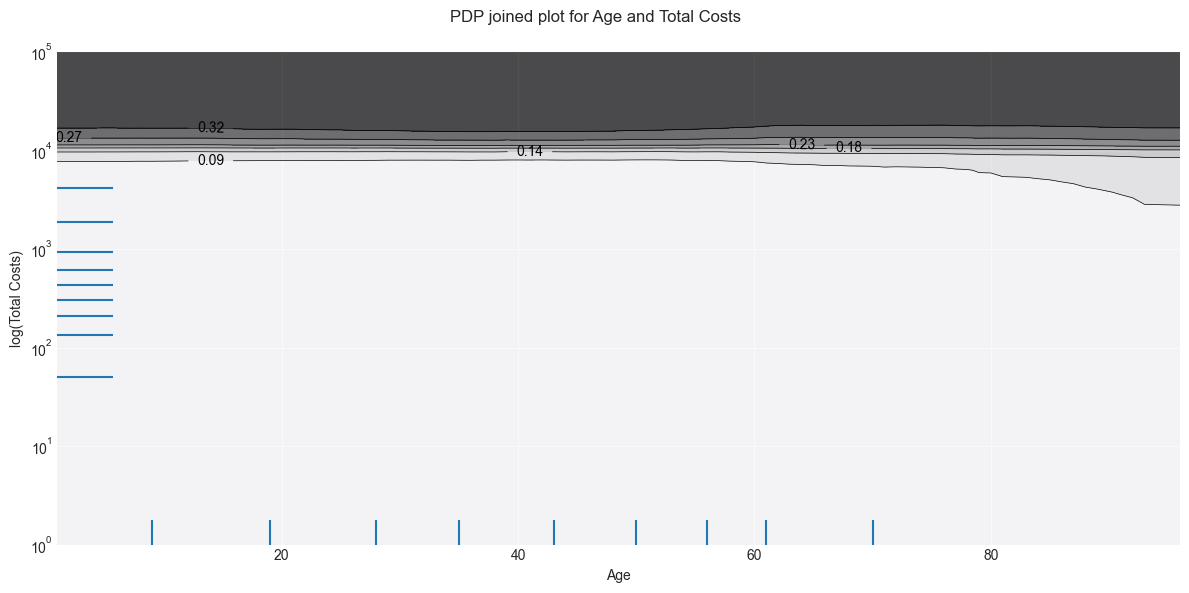

In [82]:
fig, axes = plt.subplots(ncols=len(features_idx_pdp), figsize=(12, 6), sharey=True)

plot_pd(exp_pdp,
        n_cols=len(features_idx_pdp),
        sharey='row',
        ax=axes,
        center=True)
if any([type(x) == tuple for x in features_pdp]):
        for axis, feature in zip(('x', 'y'), features_pdp[0]):
                print(axis, feature)
                if axis == 'x': 
                        axes.set_xlabel(feature.replace('_', ' '))
                        if feature == 'Total_Costs':
                                axes.set_xscale('log')
                                axes.set_xlabel('log(' + feature.replace('_', ' ') + ')')
                else:
                        axes.set_ylabel(feature.replace('_', ' '))
                        if feature == 'Total_Costs':
                                axes.set_yscale('log')
                                axes.set_ylabel('log(' + feature.replace('_', ' ') + ')')
                                axes.set_ylim(1, 10**5)
        fig.suptitle('PDP joined plot for ' + ' and '.join(features_pdp[0]).replace('_', ' '))
        if overwrite:
                fig.savefig(result_path + 'pdp_joint_' + '_'.join(features_pdp[0]))
else:
        for (axis, feature) in zip(axes, features_pdp):
                axis.set_xlabel(feature.replace('_', ' '))
                axis.set_ylabel('Probability of prospective HCP')
                if feature == 'Total_Costs':
                        axis.set_xscale('log')
                        axis.set_xlabel('log(' + feature.replace('_', ' ') + ')')
        fig.suptitle('PDP plots for ' + ' and '.join(features_pdp).replace('_', ' '))
        if overwrite:
                fig.savefig(result_path + 'pdp_' + '_'.join(features_pdp))

### ICE

Limitations: Different plots even with same explainer object

In [83]:
features_idx_ice = get_features_idx(features_ice)

exp_ice = pdp_ice.explain(X=X_test.values,
                      features=features_idx_ice,
                      kind='both',
                      grid_resolution=resolution_ice)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

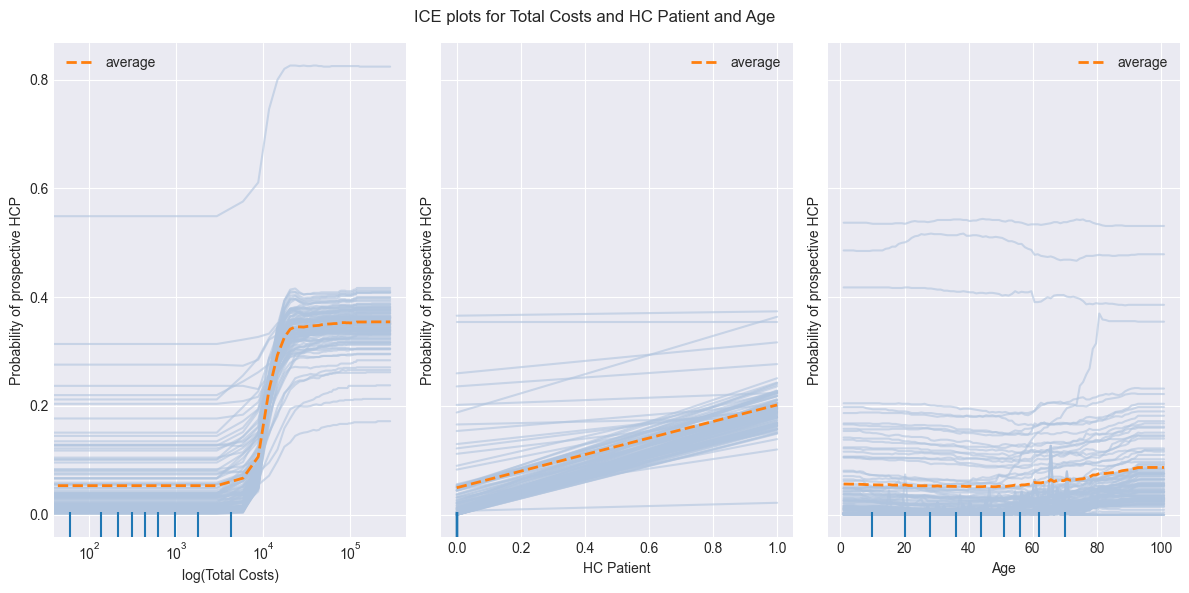

In [37]:
fig, axes = plt.subplots(ncols=len(features_idx_ice), figsize=(12, 6), sharey=True)

plot_pd(exp_ice,
        n_cols=len(features_idx_ice),
        sharey='row',
        ax=axes,
        center=False)

for (axis, feature) in zip(axes, features_ice):
        axis.set_xlabel(feature.replace('_', ' '))
        axis.set_ylabel('Probability of prospective HCP')
        if feature == 'Total_Costs':
                axis.set_xscale('log')
                axis.set_xlabel('log(' + feature.replace('_', ' ') + ')')
fig.suptitle('ICE plots for ' + ' and '.join(features_ice).replace('_', ' '))
if overwrite: 
        fig.savefig(result_path + 'ice_' + '_'.join(features_ice))

## ALE
Measures the *differences in prediction* instead of directly averaging over predictions like pdp [here](https://docs.seldon.io/projects/alibi/en/latest/methods/ALE.html)

ALE and PDP (and probably also ICE) are methods to retrieve the *feature effects* for each feature.

In [84]:
def predict_fn_ale(data):
    return model.predict_proba(data)[:,1]

In [85]:
features_idx_ale = get_features_idx(features_ale)

ale = ALE(predict_fn_ale, feature_names=predictors)
exp_ale = ale.explain(X_test.to_numpy(), features=features_idx_ale)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

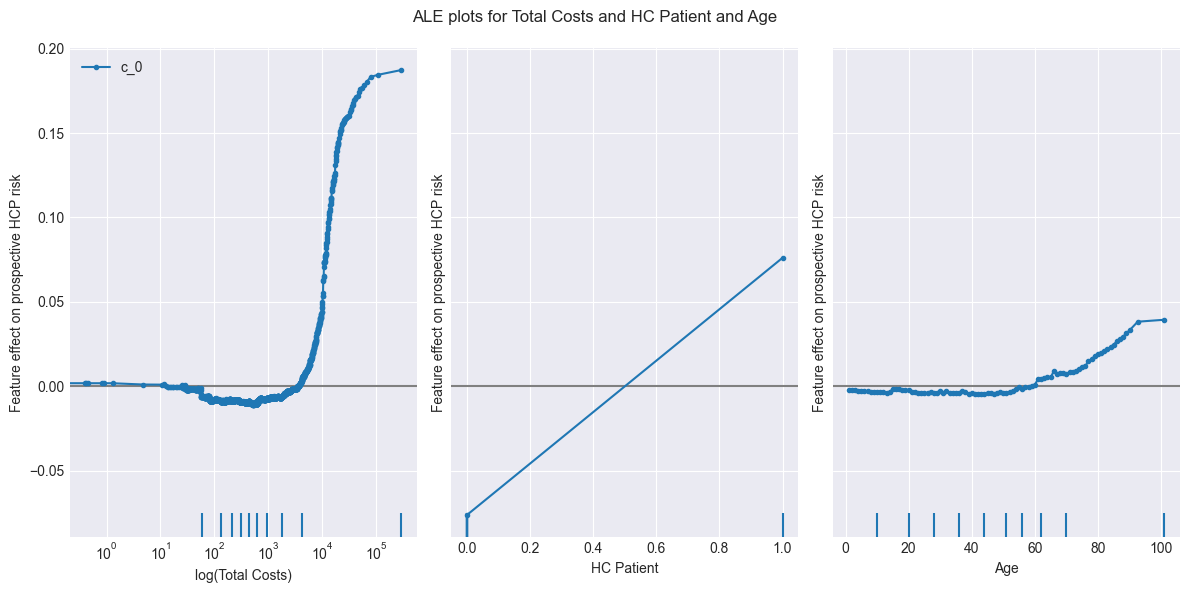

In [88]:
fig, axes = plt.subplots(ncols=len(features_idx_ale), figsize=(12, 6), sharey=True)

plot_ale(exp_ale, features=features_ale.copy(), ax=axes)

for (axis, feature) in zip(axes, features_ale):
        axis.set_xlabel(feature.replace('_', ' '))
        axis.set_ylabel('Feature effect on prospective HCP risk')
        if feature == 'Total_Costs':
                axis.set_xscale('log')
                axis.set_xlabel('log(' + feature.replace('_', ' ') + ')')
fig.suptitle('ALE plots for ' + ' and '.join(features_ale).replace('_', ' '))
if overwrite:
        fig.savefig(result_path + 'ale_' + '_'.join(features_ale))

## SHAP

In [114]:
def predict_fn_shap(data):
    # TODO: Try both options
    return model.predict_proba(data)[:,1]
    return np.array(model.predict_proba(data)[:,1] >= best_thresh, dtype=int)

In [122]:
#features_idx_shap = get_features_idx(features_shap)

# shap = KernelShap(predict_fn_shap, feature_names=predictors)
explainer_shap = KernelShap(predict_fn_shap)
explainer_shap.fit(X_train, summarise_background=True)
explanation_shap = explainer_shap.explain(shap.sample(X_test, 5), l1_reg=False)
# shap = shap.explain(X_test.to_numpy(), features=features_idx_ale)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!
  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493

### SHAP SUMMARY 

In [ ]:
shap.summary_plot(explanation_shap.shap_values[0], X_test, feature_names=predictors)

AttributeError: 'KernelShap' object has no attribute 'shap_values'

### SHAP LOCAL

In [ ]:
shap.force_plot(
    explainer_shap.expected_value[sample_prediction], 
    explainer_shap.shap_values[sample_prediction][sample_idx, :], 
    sample, 
    predictors
)

## VARIABLE IMPORTANCE
*Permutation Importance*

In [ ]:
def predict_fn_vimp(data):
    # TODO: Try both options
    return np.array(model.predict_proba(data)[:,1] >= best_thresh, dtype=int)
    return model.predict_proba(data)[:,1]

In [ ]:
explainer_vimp = PermutationImportance(predictor=predict_fn_vimp,
                                       score_fns=['accuracy', 'F1'],
                                       feature_names=predictors,
                                       verbose=True
                                       )
explanation_vimp = explainer_vimp.explain(X=X_test, y=y_test)

In [ ]:
plot_permutation_importance(explanation_vimp, 
                            ncols=2
                            )

## Anchors

Get the indexes of the columns I want to investigate. 

In [68]:
from sklearn.preprocessing import OrdinalEncoder
all_columns = train.columns

categorical_columns = all_columns[train.nunique(axis=0) == 2]
numerical_columns = [all_columns.difference(categorical_columns)]

categorical_columns_indices = [test.columns.tolist().index(cn) for cn in categorical_columns]
oe = OrdinalEncoder().fit(train[categorical_columns])
categorical_name_mapping = {i: list(v) if i < 11 else ['diagnosis absent', 'diagnosis present']
                            for (i, v) in zip(categorical_columns_indices, oe.categories_)}

In [69]:
def predict_fn_anchors(data):
    return model.predict_proba(data)[:,1]

In [70]:
features_idx_anc = get_features_idx(features_anc)

anchors = AnchorTabular(predict_fn_anchors, feature_names=predictors)
anchors.fit(X_train.values, disc_perc=(25, 50, 75))

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'seed': None, 'disc_perc': (25, 50, 75)},
  'version': '0.9.6'}
)

In [72]:
exp_anchors = anchors.explain(sample_X.to_numpy(), threshold=0.8)

c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\Sebastian's work\OneDrive - OptiMedis AG\Dokumente\Coding\High-Cost-patient-analysis\.venv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassi

In [17]:
print('Prediction: ', predict_fn_ale(samples_selected.values.reshape(1, -1)))
print('Anchor:', exp_anchors.anchor)
print('Precision: ', exp_anchors.precision)
print('Coverage: ', exp_anchors.coverage)

NameError: name 'exp_anchors' is not defined

In [ ]:
indices = X_test['Outpatient_C43'] >= 0
1 - sum(y_test[indices]) / len(y_test)

0.94998585572843

### Counterfactual explanations 

In [ ]:
shape = X_test.shape
beta = 0.1
cat_vars = None
c_init = 1.
c_steps = 10 

In [ ]:
model_cfe = 

### Contrastive Explanation Methods (CEM)

In [ ]:
sample_index = 1
X = sample.values.reshape((1,) + sample.values.shape)

mode = 'PN' # Alternative: PP (pertinent negative/positive)
shape = (1,) + X_train.values.shape[1:]
kappa = 0.2 # Minimum difference between prediction probability on predicted and other class 
beta = 0.1 # Weight of the L1 loss term 
c_init = 0.1 # Initial weight of loss term to predict different or same class 
c_steps = 10 # Number of weight updates
max_iterations = 1000 # Number of iterations per weight c 
feature_range = (X_train.values.min(axis=0).reshape(shape)-0.1,
                 X_train.values.max(axis=0).reshape(shape)+0.1) 
clip = (-1000, 1000) # Gradient clipping (constrainment of gradient)
lr_init = 0.01

KeyError: 1

In [ ]:
cem = CEM(model, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range, 
              max_iterations=max_iterations, c_init=c_init, c_steps=c_steps, 
              learning_rate_init=lr_init, clip=clip)
exp_cem = cem.explain(cem)